# 1. CAPM
модель, которая определяет ожидаемую доходность актива на основе его систематического риска (беты). В контексте алгоритмической торговли криптовалютами, CAPM помогает оценить, какую доходность должна генерировать стратегия с учетом её риска относительно рынка

### E(Rs) = Rf + βs × (E(Rm) - Rf), где:

* E(Rs) — ожидаемая доходность алгоритмической стратегии
* Rf — безрисковая ставка (для крипто часто используют доходность стейблкоин-стейкинга или US Treasury)
* βs — бета стратегии (чувствительность доходности стратегии к движениям рынка BTC)
* E(Rm) — ожидаемая доходность рынка (обычно BTC как бенчмарк)

### Бета для алгостратегии рассчитывается как:
* βs = Cov(Rs, Rm) / Var(Rm), где:
* Cov(Rs, Rm) — ковариация между доходностью стратегии и рынка (в нашем случае BTC)
* Var(Rm) — дисперсия доходности рынка

#### Пример расчета CAPM для BTC-стратегии
Представим что у нас есть какая-то стратегия за последние 30 дней (данные подобраны):

#### Исходные данные:

* Безрисковая ставка (USDT стейкинг): Rf = 4% годовых = 0.33% за 30 дней
* Средняя доходность BTC за 30 дней: Rm = 15%
* Доходность нашей стратегии за 30 дней: Rs = 8%

#### Расчет беты:
Предположим, у нас есть дневные доходности за 30 дней:

* Ковариация стратегии и BTC: Cov(Rs, Rm) = 0.0024
* Дисперсия BTC: Var(Rm) = 0.0048
* Бета: β = 0.0024 / 0.0048 = 0.5

#### Это означает, что стратегия в два раза менее волатильна, чем BTC
Расчет ожидаемой доходности по CAPM:
* E(Rs) = 0.33% + 0.5 × (15% - 0.33%)
* E(Rs) = 0.33% + 0.5 × 14.67%
* E(Rs) = 0.33% + 7.34% = 7.67%

Вывод: Наша стратегия генерирует 8% доходности, что выше ожидаемых 7.67% по CAPM. Это говорит о положительной альфе (8% - 7.67% = 0.33%)

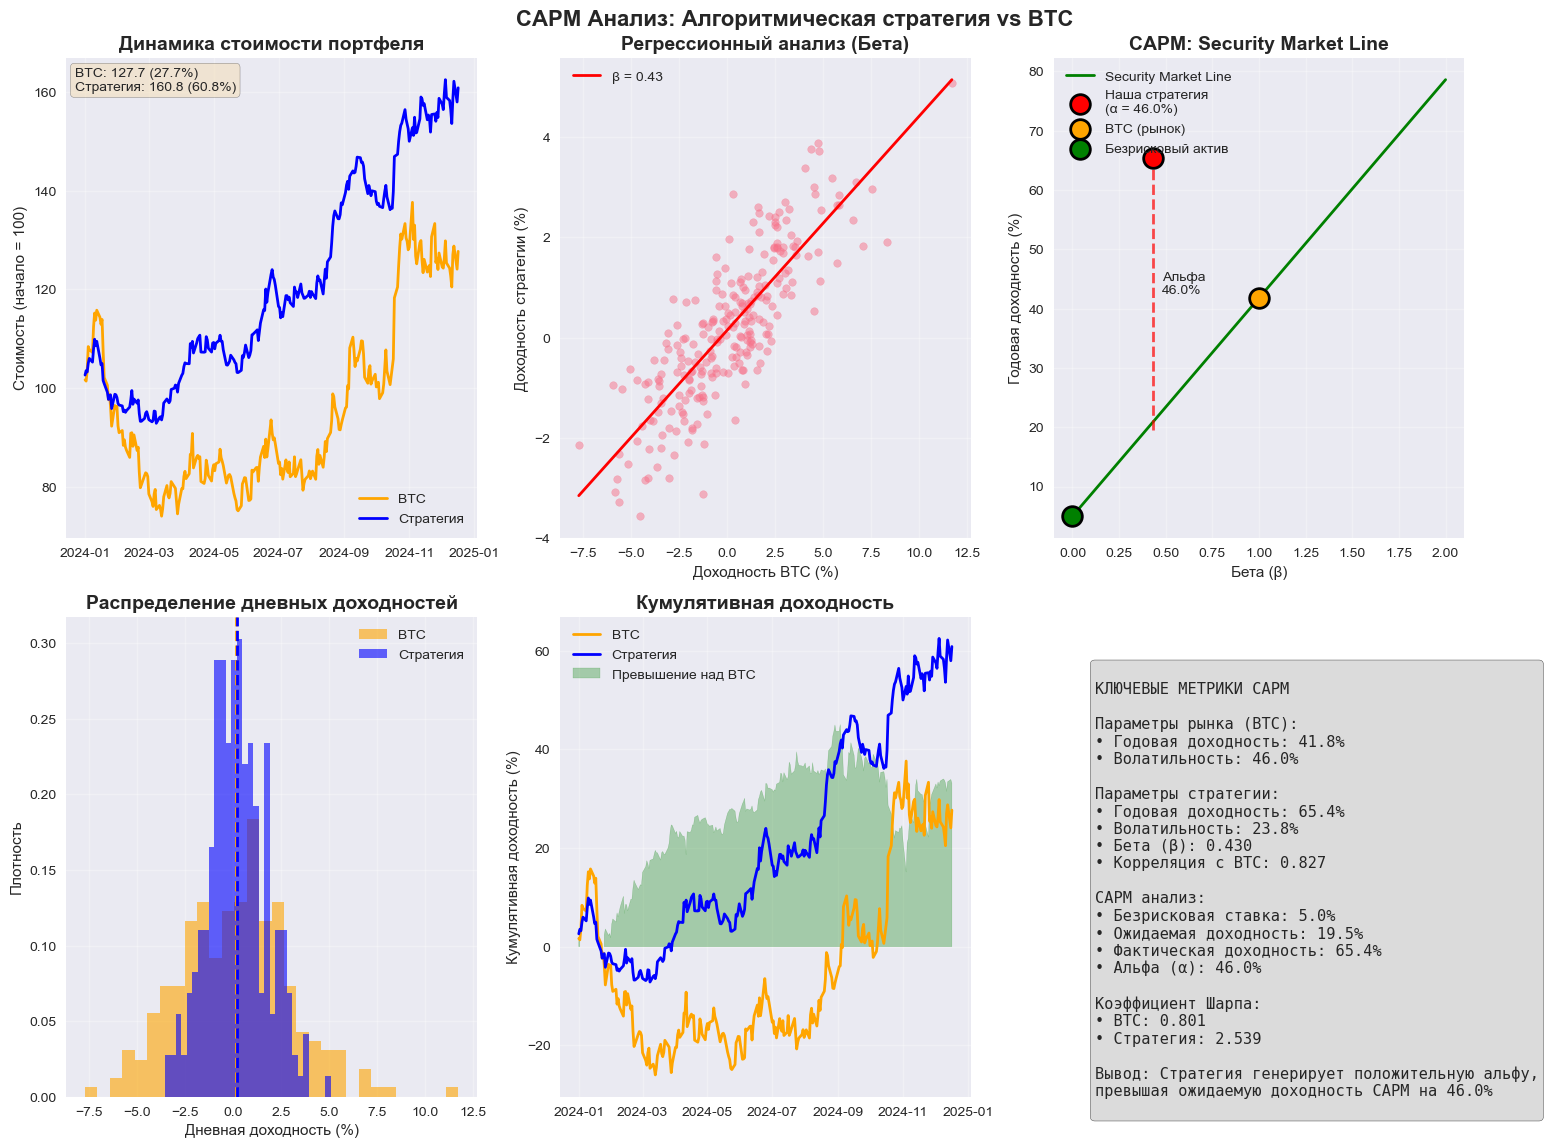

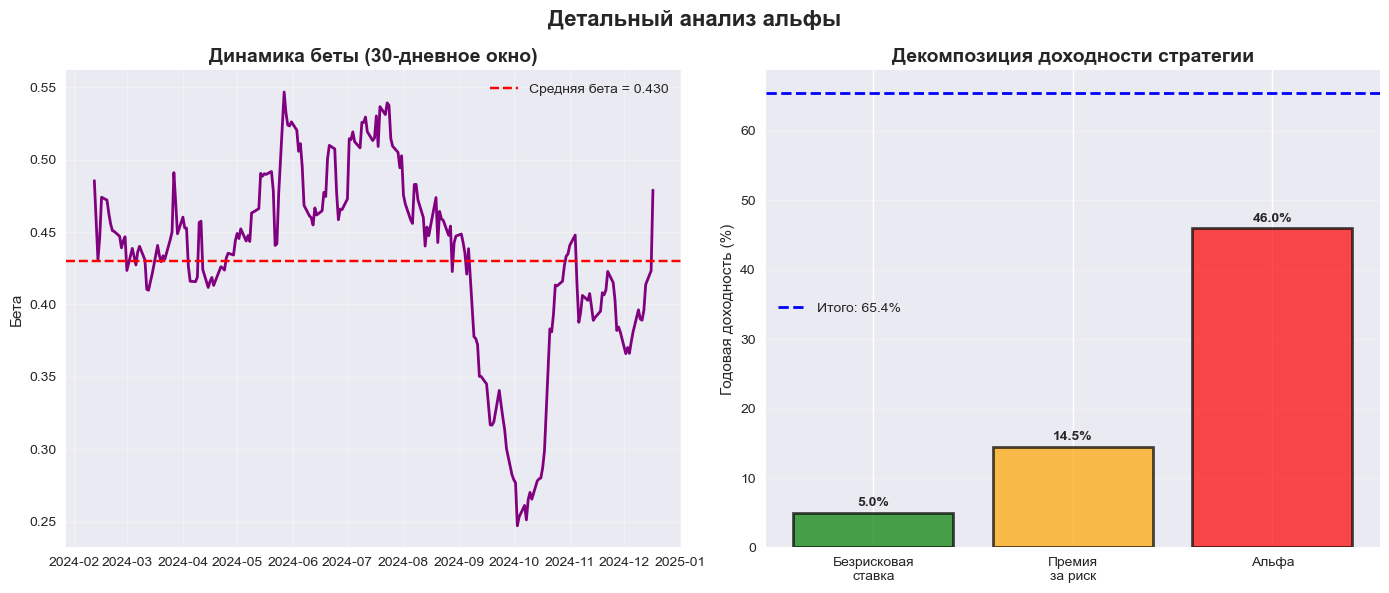

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Установка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Генерация данных за 1 год (252 торговых дня)
np.random.seed(42)
days = 252

# Параметры для симуляции
# BTC: средняя дневная доходность 0.15% (≈40% годовых), волатильность 3%
# Стратегия: средняя дневная доходность 0.20% (≈60% годовых), волатильность 1.5%
# Корреляция со рынком: 0.6

# Генерация доходностей BTC
btc_daily_mean = 0.0015  # 0.15% в день
btc_daily_std = 0.03     # 3% стандартное отклонение
btc_returns = np.random.normal(btc_daily_mean, btc_daily_std, days)

# Генерация доходностей стратегии с корреляцией к BTC
strategy_daily_mean = 0.0020  # 0.20% в день (выше чем у BTC - это создаст альфу)
strategy_daily_std = 0.015    # 1.5% стандартное отклонение (ниже чем у BTC)
correlation = 0.6

# Создаем коррелированные доходности
strategy_returns = correlation * btc_returns + np.sqrt(1 - correlation**2) * np.random.normal(0, strategy_daily_std, days)
strategy_returns = strategy_returns * (strategy_daily_std / np.std(strategy_returns))  # Нормализация волатильности
strategy_returns = strategy_returns + (strategy_daily_mean - np.mean(strategy_returns))  # Установка среднего

# Создание DataFrame
dates = pd.date_range(start='2024-01-01', periods=days, freq='B')  # B = business days
df = pd.DataFrame({
    'Date': dates,
    'BTC_Returns': btc_returns,
    'Strategy_Returns': strategy_returns
})

# Расчет цен (начинаем со 100)
df['BTC_Price'] = 100 * (1 + df['BTC_Returns']).cumprod()
df['Strategy_Value'] = 100 * (1 + df['Strategy_Returns']).cumprod()

# CAPM расчеты
risk_free_annual = 0.05  # 5% годовая безрисковая ставка
risk_free_daily = (1 + risk_free_annual) ** (1/252) - 1

# Расчет беты
covariance = np.cov(df['Strategy_Returns'], df['BTC_Returns'])[0, 1]
btc_variance = np.var(df['BTC_Returns'])
beta = covariance / btc_variance

# Средние доходности
avg_strategy_return = df['Strategy_Returns'].mean()
avg_btc_return = df['BTC_Returns'].mean()

# CAPM ожидаемая доходность
expected_return_daily = risk_free_daily + beta * (avg_btc_return - risk_free_daily)

# Альфа
alpha_daily = avg_strategy_return - expected_return_daily

# Годовые значения
annual_strategy_return = (1 + avg_strategy_return) ** 252 - 1
annual_btc_return = (1 + avg_btc_return) ** 252 - 1
annual_expected_return = (1 + expected_return_daily) ** 252 - 1
annual_alpha = annual_strategy_return - annual_expected_return

# Создание визуализации
fig = plt.figure(figsize=(16, 12))

# 1. График динамики цен
ax1 = plt.subplot(2, 3, 1)
ax1.plot(df['Date'], df['BTC_Price'], label='BTC', linewidth=2, color='orange')
ax1.plot(df['Date'], df['Strategy_Value'], label='Стратегия', linewidth=2, color='blue')
ax1.set_title('Динамика стоимости портфеля', fontsize=14, fontweight='bold')
ax1.set_ylabel('Стоимость (начало = 100)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Добавляем финальные значения
final_btc = df['BTC_Price'].iloc[-1]
final_strategy = df['Strategy_Value'].iloc[-1]
ax1.text(0.02, 0.98, f'BTC: {final_btc:.1f} ({(final_btc/100-1)*100:.1f}%)\nСтратегия: {final_strategy:.1f} ({(final_strategy/100-1)*100:.1f}%)', 
         transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Scatter plot для беты
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(df['BTC_Returns'] * 100, df['Strategy_Returns'] * 100, alpha=0.5, s=30)

# Линия регрессии
z = np.polyfit(df['BTC_Returns'], df['Strategy_Returns'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['BTC_Returns'].min(), df['BTC_Returns'].max(), 100)
ax2.plot(x_line * 100, p(x_line) * 100, "r-", linewidth=2, label=f'β = {beta:.2f}')

ax2.set_xlabel('Доходность BTC (%)')
ax2.set_ylabel('Доходность стратегии (%)')
ax2.set_title('Регрессионный анализ (Бета)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Security Market Line (SML)
ax3 = plt.subplot(2, 3, 3)
betas = np.linspace(0, 2, 100)
sml_returns = risk_free_annual + betas * (annual_btc_return - risk_free_annual)

ax3.plot(betas, sml_returns * 100, 'g-', linewidth=2, label='Security Market Line')
ax3.scatter([beta], [annual_strategy_return * 100], color='red', s=200, zorder=5, 
           label=f'Наша стратегия\n(α = {annual_alpha*100:.1f}%)', edgecolors='black', linewidth=2)
ax3.scatter([1], [annual_btc_return * 100], color='orange', s=200, zorder=5, 
           label='BTC (рынок)', edgecolors='black', linewidth=2)
ax3.scatter([0], [risk_free_annual * 100], color='green', s=200, zorder=5, 
           label='Безрисковый актив', edgecolors='black', linewidth=2)

# Показываем альфу визуально
ax3.vlines(x=beta, ymin=annual_expected_return*100, ymax=annual_strategy_return*100, 
          colors='red', linestyles='dashed', linewidth=2, alpha=0.7)
ax3.text(beta + 0.05, (annual_expected_return + annual_alpha/2)*100, 
         f'Альфа\n{annual_alpha*100:.1f}%', fontsize=10, ha='left')

ax3.set_xlabel('Бета (β)')
ax3.set_ylabel('Годовая доходность (%)')
ax3.set_title('CAPM: Security Market Line', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-0.1, 2.1)

# 4. Распределение доходностей
ax4 = plt.subplot(2, 3, 4)
ax4.hist(df['BTC_Returns'] * 100, bins=30, alpha=0.6, label='BTC', color='orange', density=True)
ax4.hist(df['Strategy_Returns'] * 100, bins=30, alpha=0.6, label='Стратегия', color='blue', density=True)
ax4.axvline(avg_btc_return * 100, color='orange', linestyle='--', linewidth=2)
ax4.axvline(avg_strategy_return * 100, color='blue', linestyle='--', linewidth=2)
ax4.set_xlabel('Дневная доходность (%)')
ax4.set_ylabel('Плотность')
ax4.set_title('Распределение дневных доходностей', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Кумулятивная доходность
ax5 = plt.subplot(2, 3, 5)
cumulative_btc = (1 + df['BTC_Returns']).cumprod() - 1
cumulative_strategy = (1 + df['Strategy_Returns']).cumprod() - 1
ax5.plot(df['Date'], cumulative_btc * 100, label='BTC', linewidth=2, color='orange')
ax5.plot(df['Date'], cumulative_strategy * 100, label='Стратегия', linewidth=2, color='blue')
ax5.fill_between(df['Date'], 0, (cumulative_strategy - cumulative_btc) * 100, 
                 where=(cumulative_strategy > cumulative_btc), alpha=0.3, color='green', label='Превышение над BTC')
ax5.set_ylabel('Кумулятивная доходность (%)')
ax5.set_title('Кумулятивная доходность', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Ключевые метрики
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

metrics_text = f"""
КЛЮЧЕВЫЕ МЕТРИКИ CAPM

Параметры рынка (BTC):
• Годовая доходность: {annual_btc_return*100:.1f}%
• Волатильность: {np.std(df['BTC_Returns'])*np.sqrt(252)*100:.1f}%

Параметры стратегии:
• Годовая доходность: {annual_strategy_return*100:.1f}%
• Волатильность: {np.std(df['Strategy_Returns'])*np.sqrt(252)*100:.1f}%
• Бета (β): {beta:.3f}
• Корреляция с BTC: {np.corrcoef(df['BTC_Returns'], df['Strategy_Returns'])[0,1]:.3f}

CAPM анализ:
• Безрисковая ставка: {risk_free_annual*100:.1f}%
• Ожидаемая доходность: {annual_expected_return*100:.1f}%
• Фактическая доходность: {annual_strategy_return*100:.1f}%
• Альфа (α): {annual_alpha*100:.1f}%

Коэффициент Шарпа:
• BTC: {(annual_btc_return - risk_free_annual)/(np.std(df['BTC_Returns'])*np.sqrt(252)):.3f}
• Стратегия: {(annual_strategy_return - risk_free_annual)/(np.std(df['Strategy_Returns'])*np.sqrt(252)):.3f}

Вывод: Стратегия генерирует положительную альфу,
превышая ожидаемую доходность CAPM на {annual_alpha*100:.1f}%
"""

ax6.text(0.1, 0.9, metrics_text, transform=ax6.transAxes, fontsize=11, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('CAPM Анализ: Алгоритмическая стратегия vs BTC', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Дополнительный график - детальный анализ альфы
fig2, (ax7, ax8) = plt.subplots(1, 2, figsize=(14, 6))

# Rolling beta (30-дневное окно)
rolling_window = 30
rolling_beta = []
rolling_dates = []

for i in range(rolling_window, len(df)):
    window_strategy = df['Strategy_Returns'].iloc[i-rolling_window:i]
    window_btc = df['BTC_Returns'].iloc[i-rolling_window:i]
    cov = np.cov(window_strategy, window_btc)[0, 1]
    var = np.var(window_btc)
    rolling_beta.append(cov / var)
    rolling_dates.append(df['Date'].iloc[i])

ax7.plot(rolling_dates, rolling_beta, linewidth=2, color='purple')
ax7.axhline(y=beta, color='red', linestyle='--', label=f'Средняя бета = {beta:.3f}')
ax7.set_title('Динамика беты (30-дневное окно)', fontsize=14, fontweight='bold')
ax7.set_ylabel('Бета')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Компоненты доходности
components = ['Безрисковая\nставка', 'Премия\nза риск', 'Альфа']
values = [risk_free_annual * 100, 
          (annual_expected_return - risk_free_annual) * 100,
          annual_alpha * 100]
colors = ['green', 'orange', 'red']

bars = ax8.bar(components, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax8.axhline(y=annual_strategy_return * 100, color='blue', linestyle='--', 
           linewidth=2, label=f'Итого: {annual_strategy_return*100:.1f}%')

# Добавляем значения на столбцы
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

ax8.set_title('Декомпозиция доходности стратегии', fontsize=14, fontweight='bold')
ax8.set_ylabel('Годовая доходность (%)')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

plt.suptitle('Детальный анализ альфы', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### 2. Fama-French 3-Factor Model
* Расширяет CAPM, добавляя факторы размера (SMB) и стоимости (HML)
* Формула: R_strategy - R_f = α + β₁(R_market - R_f) + β₂(SMB) + β₃(HML) + ε
* Позволяет отделить "настоящую" альфу от простой экспозиции к известным факторам

#### 3. Carhart 4-Factor Model
* Добавляет momentum фактор (WML - Winners Minus Losers) к Fama-French
* Формула: R_strategy - R_f = α + β₁(R_market - R_f) + β₂(SMB) + β₃(HML) + β₄(WML) + ε

#### 4. Custom Multi-Factor Models
Модели с факторами, специфичными для конкретной стратегии

Примеры дополнительных факторов для алгостратегий:
* Liquidity factor — для HFT и маркет-мейкинг стратегий
* Volatility factor — для опционных стратегий и volatility arbitrage
* Trend factor — для futures стратегий
* Crowding factor — учитывает популярность определенных trades

* Формула: R_strategy - R_f = α + Σ(βᵢ × Factorᵢ) + ε